In [1]:
import os
import cv2
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

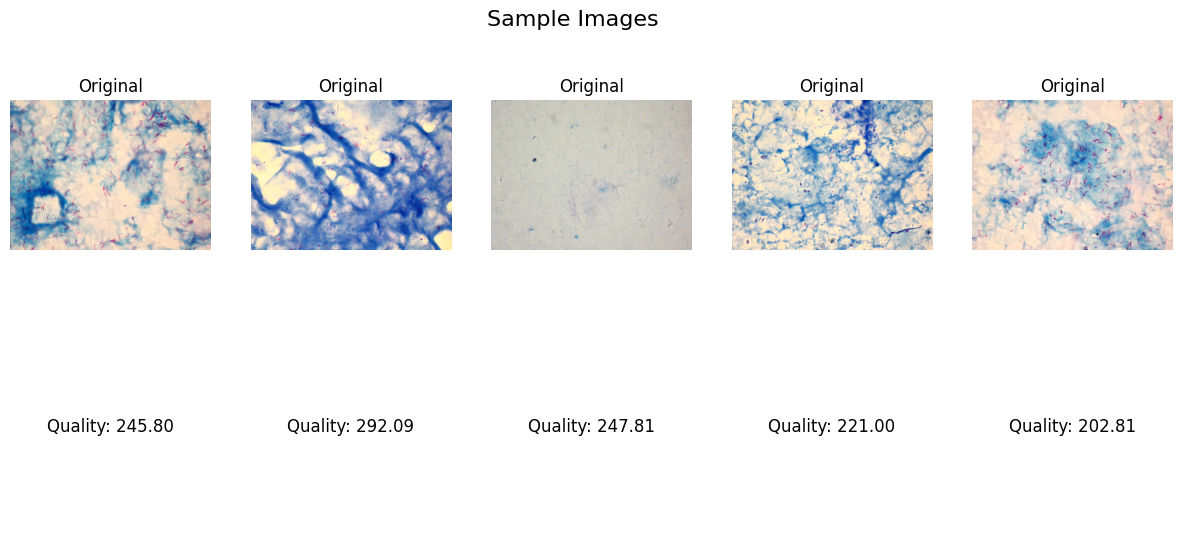

In [4]:
def compute_image_quality(image):
    # Compute image quality metrics (e.g., sharpness, brightness, etc.)
    # Here, we'll just compute the variance of Laplacian to measure image sharpness
    return cv2.Laplacian(image, cv2.CV_64F).var()

def visualize_sample_images(folder_path, num_samples=5):
    # Check if the folder exists
    if not os.path.exists(folder_path):
        print(f"Error: Folder '{folder_path}' does not exist.")
        return
    
    # Get a list of all files in the folder
    files = os.listdir(folder_path)
    
    num_images = len(files)
    
    if num_images == 0:
        print(f"No images found in the folder '{folder_path}'.")
        return
    
    # Randomly select image file names
    random_files = random.sample(files, min(num_samples, num_images))
    
    # Plot the sample images
    fig, axes = plt.subplots(2, len(random_files), figsize=(15, 6))
    fig.suptitle('Sample Images', fontsize=16)
    
    for i, file_name in enumerate(random_files):
        file_path = os.path.join(folder_path, file_name)
        img = mpimg.imread(file_path)
        
        # Visualize the original image
        axes[0, i].imshow(img)
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')
        
        # Compute and display image quality
        quality = compute_image_quality(img)
        axes[1, i].text(0.5, 0.5, f'Quality: {quality:.2f}', ha='center', va='center', fontsize=12)
        axes[1, i].axis('off')
    
    plt.show()

# Example usage:
visualize_sample_images(r"C:\Users\USER\Desktop\Implementation\Images")

In [5]:
def resize_images_in_folder(folder_path, output_folder, target_size=(2816, 2112)):
    # Check if the input folder exists
    if not os.path.exists(folder_path):
        print(f"Error: Input folder '{folder_path}' does not exist.")
        return
    
    # Check if the output folder exists, create it if not
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Get a list of all files in the input folder
    files = os.listdir(folder_path)
    
    num_images = len(files)
    
    if num_images == 0:
        print(f"No images found in the folder '{folder_path}'.")
        return
    
    # Resize each image and save it to the output folder
    for file_name in files:
        input_path = os.path.join(folder_path, file_name)
        output_path = os.path.join(output_folder, file_name)
        
        # Load the image
        img = cv2.imread(input_path)
        
        # Resize the image
        resized_img = cv2.resize(img, target_size)
        
        # Save the resized image
        cv2.imwrite(output_path, resized_img)
        
    print(f"Resized images saved to '{output_folder}'.")

# Example usage:
resize_images_in_folder(r"C:\Users\USER\Desktop\Implementation\Images", r"C:\Users\USER\Desktop\Implementation\ResizedImages")

Resized images saved to 'C:\Users\USER\Desktop\Implementation\ResizedImages'.


In [6]:
def adjust_contrast_in_folder(folder_path, output_folder, alpha=1.0, beta=0.0):
    # Check if the input folder exists
    if not os.path.exists(folder_path):
        print(f"Error: Input folder '{folder_path}' does not exist.")
        return
    
    # Check if the output folder exists, create it if not
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Get a list of all files in the input folder
    files = os.listdir(folder_path)
    
    num_images = len(files)
    
    if num_images == 0:
        print(f"No images found in the folder '{folder_path}'.")
        return
    
    # Adjust contrast of each image and save it to the output folder
    for file_name in files:
        input_path = os.path.join(folder_path, file_name)
        output_path = os.path.join(output_folder, file_name)
        
        # Load the image
        img = cv2.imread(input_path)
        
        # Adjust contrast using alpha and beta parameters
        adjusted_img = np.clip(alpha * img + beta, 0, 255).astype(np.uint8)
        
        # Save the adjusted image
        cv2.imwrite(output_path, adjusted_img)
        
    print(f"Contrast-adjusted images saved to '{output_folder}'.")

# Example usage:
adjust_contrast_in_folder(r"C:\Users\USER\Desktop\Implementation\ResizedImages", r"C:\Users\USER\Desktop\Implementation\ContrastAdjustedImages", alpha=1.5, beta=20)

Contrast-adjusted images saved to 'C:\Users\USER\Desktop\Implementation\ContrastAdjustedImages'.


In [7]:
def split_data(input_folder, output_folder, train_size=0.8, test_size=0.1, val_size=0.1, random_state=None):
    # Check if the input folder exists
    if not os.path.exists(input_folder):
        print(f"Error: Input folder '{input_folder}' does not exist.")
        return
    
    # Create output folders for train, test, and validation sets
    train_folder = os.path.join(output_folder, "train")
    test_folder = os.path.join(output_folder, "test")
    val_folder = os.path.join(output_folder, "val")
    
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)
    os.makedirs(val_folder, exist_ok=True)
    
    # Get a list of all files in the input folder
    files = os.listdir(input_folder)
    
    num_files = len(files)
    
    if num_files == 0:
        print(f"No files found in the folder '{input_folder}'.")
        return
    
    # Split the data into train, test, and validation sets
    train_files, test_val_files = train_test_split(files, train_size=train_size, random_state=random_state)
    test_files, val_files = train_test_split(test_val_files, train_size=test_size / (test_size + val_size), random_state=random_state)
    
    # Copy files to respective train, test, and validation folders
    copy_files(train_files, input_folder, train_folder)
    copy_files(test_files, input_folder, test_folder)
    copy_files(val_files, input_folder, val_folder)
    
    print(f"Data split into train, test, and validation sets. Train set: {len(train_files)}, Test set: {len(test_files)}, Validation set: {len(val_files)}")

def copy_files(files, source_folder, destination_folder):
    for file_name in files:
        source_path = os.path.join(source_folder, file_name)
        destination_path = os.path.join(destination_folder, file_name)
        shutil.copyfile(source_path, destination_path)

# Example usage:
split_data(r"C:\Users\USER\Desktop\Implementation\ResizedImages", r"C:\Users\USER\Desktop\Implementation\DataSplit")

Data split into train, test, and validation sets. Train set: 96, Test set: 12, Validation set: 12


In [3]:
def augment_train_data(train_folder, output_folder, batch_size=32, augment_params=None, num_augmented_images=192):
    # Check if the train folder exists
    if not os.path.exists(train_folder):
        print(f"Error: Train folder '{train_folder}' does not exist.")
        return
    
    # Create output folder for augmented data
    os.makedirs(output_folder, exist_ok=True)
    
    # Initialize ImageDataGenerator for data augmentation
    if augment_params is None:
        augment_params = {
            'rotation_range': 20,
            'width_shift_range': 0.2,
            'height_shift_range': 0.2,
            'shear_range': 0.2,
            'zoom_range': 0.2,
            'horizontal_flip': True,
            'fill_mode': 'nearest'
        }
    
    datagen = ImageDataGenerator(**augment_params)
    
    # Create generator for reading images from train folder
    train_generator = datagen.flow_from_directory(train_folder,
                                                  target_size=(2816, 2112),  # Set your target image size
                                                  batch_size=batch_size,
                                                  class_mode='categorical', # Set the class mode according to your dataset
                                                  shuffle=True,
                                                  save_to_dir=output_folder,
                                                  save_prefix='augmented',
                                                  save_format='jpg')
    # Generate augmented images until reaching or exceeding the specified number of augmented images
    generated_images = 0
    for _ in range(num_augmented_images // batch_size):
        batch = next(train_generator)
        generated_images += batch[0].shape[0]  # Update the count of generated images
    
    if num_augmented_images % batch_size != 0:
        # Generate additional images if needed to reach the desired count
        batch = next(train_generator)
        generated_images += batch[0].shape[0]
    
    print(f"Augmented training data saved to '{output_folder}'.")
    print(f"Total augmented images generated: {generated_images}")

# Example usage:
augment_train_data(r"C:\Users\USER\Desktop\Implementation\DataSplit\train", r"C:\Users\USER\Desktop\Implementation\AugmentedData", num_augmented_images=192)

Found 96 images belonging to 12 classes.
Augmented training data saved to 'C:\Users\USER\Desktop\Implementation\AugmentedData'.
Total augmented images generated: 192


In [3]:
# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 12

# Create VGG model
def create_vgg_model(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    return model

model = create_vgg_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Path to the augmented training data folder (which now contains all classes)
train_folder = r"C:\Users\USER\Desktop\Implementation\AugmentedData"

# Set up ImageDataGenerator for training data with normalization
batch_size = 32
train_datagen = ImageDataGenerator(rescale=1./255)

# Flow the data from the combined data folder
train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

# Calculate steps per epoch
steps_per_epoch = train_generator.n // batch_size

# Train the model
epochs = 10
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 27,566,412 (105.16 MB)

 Trainable params: 12,851,724 (49.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Found 288 images belonging to 12 classes.
Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 89s 8s/step - accuracy: 0.0982 - loss: 5.6634
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 84s 8s/step - accuracy: 0.1873 - loss: 4.0528
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 80s 8s/step - accuracy: 0.3133 - loss: 2.0810
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 84s 8s/step - accuracy: 0.4633 - loss: 1.6268
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 89s 9s/step - accuracy: 0.3965 - loss: 1.6690
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
